# Import libraries

In [ ]:
import json
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
import os

Download data from Kaggle

In [ ]:
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

api_token = {"username":"thnhnguyenphuc","key":"c4567d6a802976fa686fb1f293c5ce5f"}

import json

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
from kaggle.api.kaggle_api_extended import KaggleApi

# https://technowhisp.com/kaggle-api-python-documentation/
# Authenticate to Kaggle
api = KaggleApi()
api.authenticate()

# Download the dataset
api.dataset_download_files('duyminhnguyentran/csc15105', unzip=True)

Path to data file (change if necessary)

In [ ]:
file_path_train = "Project2_Data/train.json"
file_path_test = "Project2_Data/test.json"

# Perform EDA on data

In [ ]:
with open(file_path_train, "r") as train_set:
    train_data = json.load(train_set)

with open(file_path_test, "r") as test_set:
    test_data = json.load(test_set)


In [ ]:
for item in train_data:
    for qas in item['qas']:
        if qas['answers'][0]['answer_start'] == -1:
            qas['answers'][0]['answer_start'] = item['context'].find(qas['answers'][0]['text'])
    item['qas'] = [qas for qas in item['qas'] if len(qas['answers'][0]['text']) >= 1 or qas['answers'][0]['text'].isdigit()]
    item['qas'] = [qas for qas in item['qas'] if len(qas['question']) >= 1]
with open('modified_train_data.json', 'w') as file:
    json.dump(train_data, file, indent=4)

for item in test_data:
    for qas in item['qas']:
        if qas['answers'][0]['answer_start'] == -1:
            qas['answers'][0]['answer_start'] = item['context'].find(qas['answers'][0]['text'])
    item['qas'] = [qas for qas in item['qas'] if len(qas['answers'][0]['text']) >= 1 or qas['answers'][0]['text'].isdigit()]
    item['qas'] = [qas for qas in item['qas'] if len(qas['question']) >= 1]
with open('modified_test_data.json', 'w') as file:
    json.dump(test_data, file, indent=4)

In [ ]:
file_path_train = "modified_train_data.json"
file_path_test = "modified_test_data.json"

In [ ]:
with open(file_path_train, "r") as train_set:
    train_data = json.load(train_set)

with open(file_path_test, "r") as test_set:
    test_data = json.load(test_set)

data = train_data + test_data

with open('data.json', 'w', encoding='utf-8') as merged_file:
    json.dump(data, merged_file, ensure_ascii=False, indent=4)

df = pd.DataFrame(data)

In [ ]:
def extract_qas_features(df):
  qas_data = df['qas'].tolist()
  features_list = []

  for k, sample in enumerate(qas_data):
    qas_len = len(sample)
    context = df['context'][k]
    for i in range(qas_len):
      id = sample[i]['id']
      question = sample[i]['question']
      answer_text = sample[i]['answers'][0]['text']
      answer_start = sample[i]['answers'][0]['answer_start']
      is_impossible = sample[i]['is_impossible']
      features_list.append(pd.Series([context, id, question, answer_text, answer_start, is_impossible]))

  return pd.DataFrame(features_list)

In [ ]:
df = df[df['qas'].apply(lambda x: bool(x))]
df = df.reset_index(drop=True)

In [ ]:
df = extract_qas_features(df.copy())
df.columns = ['context','id', 'question', 'answer_text', 'answer_start', 'is_impossible']

df['answer_length'] = df['answer_text'].apply(len)

df.head()

,context,id,question,answer_text,answer_start,is_impossible,answer_length
0,"Về mặt kiến ​​trúc, trường có một nhân vật Côn...",5733be284776f4190066117e,Có gì ngồi trên đầu trang của Tòa nhà Chính tạ...,bức tượng vàng của Đức Trinh Nữ Maria,98,False,37
1,"Về mặt kiến ​​trúc, trường có một nhân vật Côn...",5733be284776f4190066117f,là những gì ở phía trước của Notre Dame Tòa nh...,một bức tượng đồng của Chúa Kitô,200,False,32
2,"Về mặt kiến ​​trúc, trường có một nhân vật Côn...",5733be284776f41900661180,Vương Cung Thánh Đường của trái tim Thánh tại ...,Tòa nhà Chính,304,False,13
3,"Về mặt kiến ​​trúc, trường có một nhân vật Côn...",5733be284776f41900661181,các Grotto tại Notre Dame là gì?,một nơi Marian cầu nguyện và suy,393,False,32
4,"Về mặt kiến ​​trúc, trường có một nhân vật Côn...",5733be284776f41900661182,Mà đã bị cáo buộc Đức Trinh Nữ Maria xuất hiện...,Saint Bernadette Soubirous,520,False,26


In [ ]:
print("\nBasic statistics of the DataFrame:")
df[['context', 'question', 'answer_text', 'is_impossible']].describe()


Basic statistics of the DataFrame:


,context,question,answer_text,is_impossible
count,65092,65092,65092,65092
unique,11941,49148,37871,1
top,Beyoncé Giselle Knowles-Carter (/ biːjɒnseɪ / ...,Ai thắng trong mùa giải này của thần tượng?,",",False
freq,38,12,210,65092


In [ ]:
df.shape[0]

65092

In [ ]:
print("\nMissing values:")
df.isnull().sum()


Missing values:


context          0
id               0
question         0
answer_text      0
answer_start     0
is_impossible    0
answer_length    0
dtype: int64

In [ ]:
# prompt: give me all rows that has is_impossible == False and context or question or answer_text < 3

df[(df['is_impossible'] == False) & ((df['context'].str.len() < 3) | (df['question'].str.len() < 2) | (df['answer_text'].str.len() < 2))]


,context,id,question,answer_text,answer_start,is_impossible,answer_length
21,Tất cả các sinh viên đại học Notre Dame là một...,5733a70c4776f41900660f65,Mà tổ chức tuyên bố là Năm Đầu Tiên của nghiên...,U,646,False,1
114,"Mục sư Theodore Hesburgh, CSC, (1917-2015) từn...",573393184776f41900660da9,kích thước của các khoản hiến tặng Notre Dame ...,$,266,False,1
442,album studio thứ tư của cô 4 được phát hành và...,56d4c4532ccc5a1400d83204,tên của album studio thứ tư của Beyonce là gì?,4,27,False,1
543,"Trên 7 tháng 1 năm 2012, Beyoncé đã sinh ra mộ...",56bfacdda10cfb140055122d,Ai đã được ghi cho tiếng kêu của cô trên bài hát?,B,484,False,1
544,"Trên 7 tháng 1 năm 2012, Beyoncé đã sinh ra mộ...",56d4d2232ccc5a1400d83266,Làm thế nào được Blue Ivy ghi trên Glory?,B,484,False,1
...,...,...,...,...,...,...,...
64552,Bern là quê hương của 8 thư viện. Những thư vi...,56e9641f99e8941900975f91,Có bao nhiêu thư viện là ở Bern?,8,22,False,1
64668,Những người phản đối cho rằng tiết kiệm năng l...,56e7594900c9c71400d76ff6,Có gì nguy cơ sức khỏe nghiêm trọng làm người ...,",",139,False,1
64674,tiềm năng DST để tiết kiệm năng lượng chủ yếu ...,56e75e3b37bdd419002c3eff,Bao nhiêu phần trăm của tất cả các sử dụng điệ...,3,117,False,1
64914,"Các văn khố đầu tiên, R. DW Connor, bắt đầu ph...",56e77ae437bdd419002c400d,Ai là lưu trữ văn đầu tiên tại Lưu trữ Quốc gia?,R,22,False,1


In [ ]:
len(df[df['question'].str.len() < 2])

5

In [ ]:
len(df[df['answer_text'].str.len() < 2])

918

# Word cloud

Text

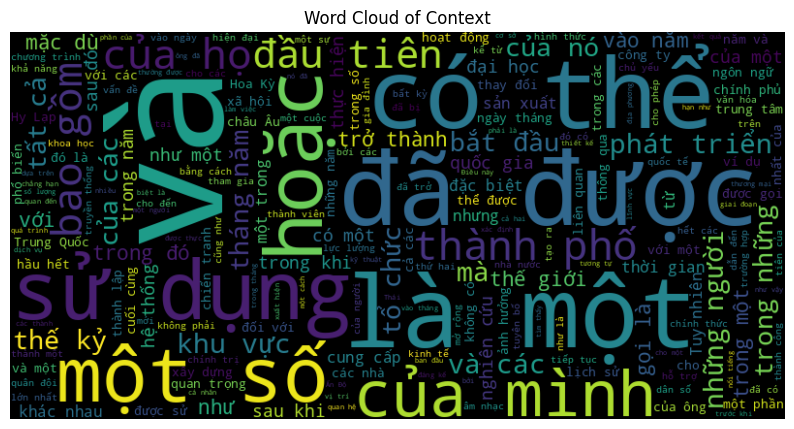

In [ ]:
text = " ".join(df['context'].unique())

wordcloud = WordCloud(width=800, height=400, background_color='black').generate(text)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Context')
plt.show()

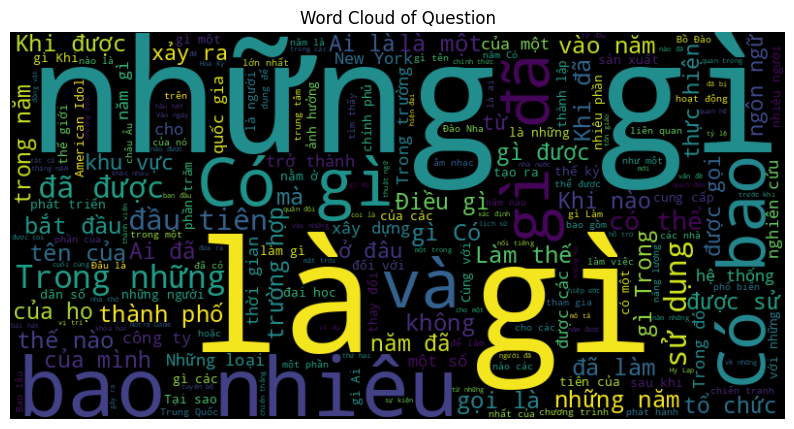

In [ ]:
text = " ".join(df['question'])

wordcloud = WordCloud(width=800, height=400, background_color='black').generate(text)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Question')
plt.show()

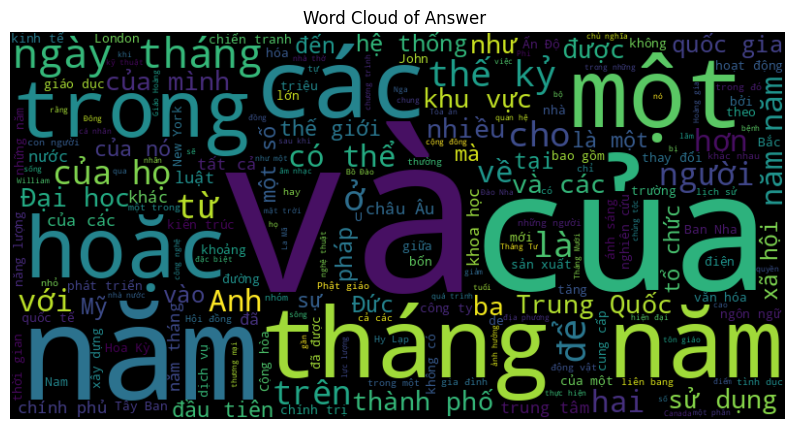

In [ ]:
text = " ".join(df['answer_text'])

wordcloud = WordCloud(width=800, height=400, background_color='black').generate(text)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Answer ')
plt.show()

Question

# Lable ratio

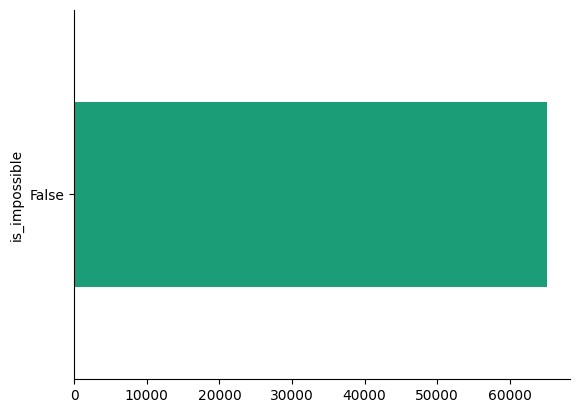

In [ ]:
df.groupby('is_impossible').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)


# Length of question and text

In [ ]:
df['context_length'] = df['context'].apply(len)

print("\nStatistics of Context Length:")
df['context_length'].describe()


Statistics of Context Length:


count    65092.000000
mean       777.197090
std        367.961887
min        131.000000
25%        536.000000
50%        709.000000
75%        959.000000
max       3280.000000
Name: context_length, dtype: float64

In [ ]:
df['question_length'] = df['question'].apply(len)

print("\nStatistics of Question Length:")
df['question_length'].describe()



Statistics of Question Length:


count    65092.000000
mean        61.879555
std         23.419809
min          1.000000
25%         45.000000
50%         59.000000
75%         75.000000
max        277.000000
Name: question_length, dtype: float64

In [ ]:
df['answer_length'] = df['answer_text'].apply(len)

print("\nStatistics of Answer Length:")
df['answer_length'].describe()


Statistics of Answer Length:


count    65092.000000
mean        19.995314
std         27.897840
min          1.000000
25%          7.000000
50%         13.000000
75%         22.000000
max       1135.000000
Name: answer_length, dtype: float64

In [ ]:
df['answer_start'].describe()

count    65092.000000
mean       317.246912
std        287.314598
min          0.000000
25%         98.000000
50%        243.000000
75%        459.000000
max       3180.000000
Name: answer_start, dtype: float64